# Temperaturas Nueva York (1870-2020)

## Problema
Modelar y pronosticar las temperaturas promedio anuales en Nueva York usando datos históricos de 151 años para capturar patrones temporales y tendencias de calentamiento global mediante modelos estadísticos robustos.
## Objetivo
Implementar y evaluar modelos ARIMA para determinar la configuración óptima que mejor capture la dinámica climática, comparando criterios de optimización automática (AIC) vs. interpretación estadística (ACF/PACF).
## Metodología:
- **Preparación:** Limpieza y visualización de datos (división 90%-10%)
- **Estacionariedad:** Prueba ADF y diferenciación automática
- **Identificación:** Análisis ACF/PACF para parámetros p y q
- **Optimización:** Búsqueda sistemática por AIC de configuraciones ARIMA
- **Evaluación:** Comparación usando RMSE, MAPE y análisis visual
- **Selección:** Criterio híbrido estadístico-visual para el modelo final


In [1]:
# Importamos las librerias necesarias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Cargamos y preparamos nuestros datos
df = pd.read_csv("TempNY.csv")
df = df.drop("Unnamed: 2", axis=1) #Elimiono la columna inecesaria
df.index = pd.to_datetime(df["Year"], format='%Y') # Establezco el año como indice y agrego el formato
df = df.drop("Year", axis=1)
df

,Average
Year,
1870-01-01,53.60
1871-01-01,51.13
1872-01-01,50.98
1873-01-01,50.98
1874-01-01,51.34
...,...
2016-01-01,57.18
2017-01-01,56.22
2018-01-01,55.88


<Axes: xlabel='Year'>

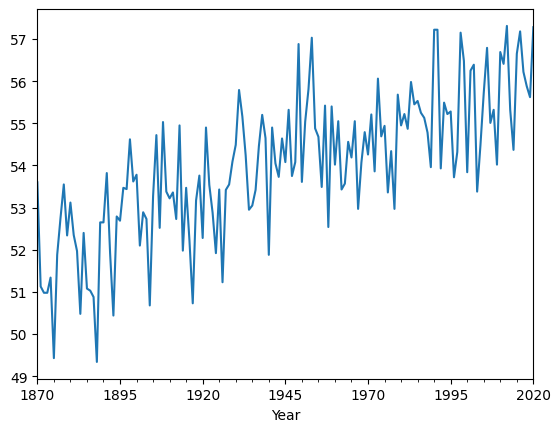

In [3]:
# Imprimimos nuestra gráfica para vizualizar el comportamiento
df["Average"].plot()

### La tendencia de crecimiento en las temperaturas es visible en los datos,por lo que debemos trabajar en la estacionalidad

In [4]:
# Dividir los datos en entrenamiento (90%) y prueba (10%)
# Después los llamamos para visualizarlos
train_size = int(len(df) * 0.9)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]
train_data

,Average
Year,
1870-01-01,53.60
1871-01-01,51.13
1872-01-01,50.98
1873-01-01,50.98
1874-01-01,51.34
...,...
2000-01-01,53.84
2001-01-01,56.25
2002-01-01,56.39


In [5]:
test_data

,Average
Year,
2005-01-01,55.72
2006-01-01,56.79
2007-01-01,55.01
2008-01-01,55.32
2009-01-01,54.02
2010-01-01,56.69
2011-01-01,56.41
2012-01-01,57.31
2013-01-01,55.32


In [6]:
# Verificamos la estacionariedad de los datos de entrenamiento,  prueba de Dickey-Fuller aumentada (ADF) 
print("--- Verificación de estacionariedad ---") #Imprimimos el Títilo para los valores que arrojará nuestro ciclo
adfuller_result = adfuller(train_data["Average"])
p_value = adfuller_result[1]
print(f"El valor p de la prueba de Dickey-Fuller es: {p_value:.14f}")
if p_value > 0.05: # Usamos un ciclo de verificación el cual va a estar en función de la prueba de Dickey-Fulle 
    print("La serie no es estacionaria. Aplicando diferenciación...")
    # Aplicar primera diferencia
    temp_diff = train_data["Average"].diff().dropna()
    d = 1
    
    # Ahora probaremos la estacionariedad en la serie diferenciada
    adfuller_result_diff = adfuller(temp_diff)
    p_value_diff = adfuller_result_diff[1]
    print(f"El valor p después de la primera diferenciación es: {p_value_diff:.14f}")
    if p_value_diff > 0.05:
        # Aplicar segunda diferencia (Esta entra en caso de ser necesaria)
        temp_diff_2 = temp_diff.diff().dropna()
        d = 2
        adfuller_result_diff_2 = adfuller(temp_diff_2)
        p_value_diff_2 = adfuller_result_diff_2[1]
        print(f"El valor p después de la segunda diferenciación es: {p_value_diff_2:.14f}")
        if p_value_diff_2 <= 0.05: # Ojo, nuestro ciclo para cuando p_value_diff_2 es menor o igual a 0.05 Tambien pedimos que nos de la impresión de los resultados para tener presente estos valores y las veces que requerimos pasar por este paso
            print("La serie se ha vuelto estacionaria con 2 diferenciaciones.")
            print("El parámetro 'd' es 2.")
        else:
            print("La serie aún no es estacionaria. Se necesitarían más diferenciaciones.")
    else:
        print("La serie se ha vuelto estacionaria con 1 diferenciación.")
        print("El parámetro 'd' es 1.")
else:
    print("La serie ya es estacionaria. El parámetro 'd' es 0.")

--- Verificación de estacionariedad ---
El valor p de la prueba de Dickey-Fuller es: 0.42201206191181
La serie no es estacionaria. Aplicando diferenciación...
El valor p después de la primera diferenciación es: 0.00000000000016
La serie se ha vuelto estacionaria con 1 diferenciación.
El parámetro 'd' es 1.


### Los resultados de la prueba de Dickey-Fuller demuestran que la serie de tiempo de temperaturas no es estacionaria en su estado original, ya que el valor p de 0.422 es significativamente mayor que el umbral de 0.05. Pero, al aplicar una primera diferenciación el nuevo valor p se reduce a 0.00000000000016, este ya es un valor mucho menor que 0.05. En este punto podemos confirmar que la serie se ha vuelto estacionaria, lo que significa que el parámetro d del modelo ARIMA, que representa el número de diferenciaciones necesarias, es igual a 1.

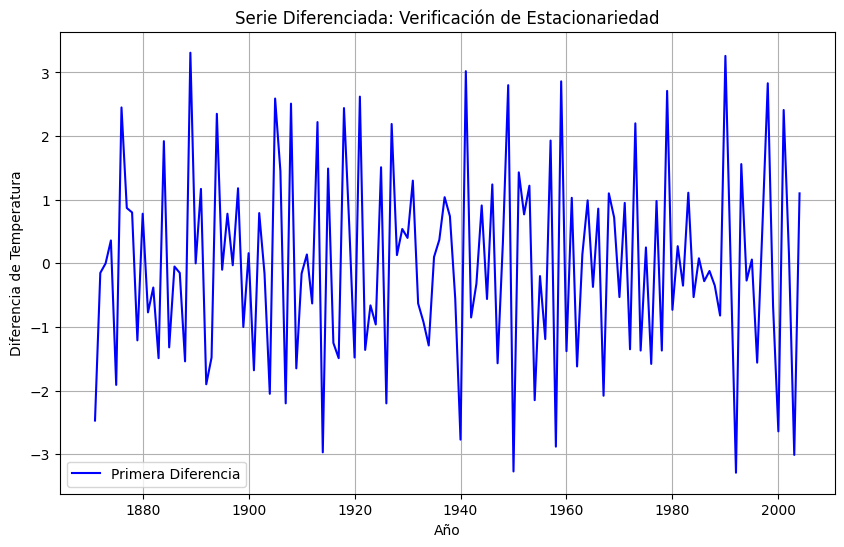

In [7]:
# Generamos la grafica solo para corroborar la estacionalidad, después de haber calculado temp_diff (la primera diferencia)
temp_diff = train_data["Average"].diff().dropna()

# Gráfica de la serie diferenciada
plt.figure(figsize=(10, 6))
plt.plot(temp_diff, label="Primera Diferencia", color="blue")
plt.title("Serie Diferenciada: Verificación de Estacionariedad")
plt.xlabel("Año")
plt.ylabel("Diferencia de Temperatura")
plt.legend()
plt.grid(True)
plt.show()  # Esto muestra la gráfica

In [8]:
# Encontrar los parámetros p y q óptimos usando AIC
print("\n--- Búsqueda de parámetros óptimos ---")
best_aic = float('inf') #iniciamos nuestra variable con un valor infinito
best_order = None # Donde almacenaremos p, d, q
orders_to_test = [(1, d, 0), (0, d, 1), (1, d, 1), (2, d, 0), (0, d, 2), (2, d, 1), (1, d, 2), (2, d, 2)] # Definimos nuestras Tuplas

# Generamos nuestro Bucle poara encontrar las mejores combinaciones de nuestros parametros p, d, q
for p, d, q in orders_to_test:
    try:
        model = ARIMA(train_data["Average"], order=(p, d, q))
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p, d, q)
        print(f"Combinación ARIMA({p}, {d}, {q}) -> AIC: {results.aic:.4f}") #Nos imprima los valores generados
    except:
        continue

print(f"\nEl modelo ARIMA óptimo es: {best_order} con un AIC de: {best_aic:.4f}") #Imprima el modelo optimo


--- Búsqueda de parámetros óptimos ---
Combinación ARIMA(1, 1, 0) -> AIC: 462.2953
Combinación ARIMA(0, 1, 1) -> AIC: 433.6565
Combinación ARIMA(1, 1, 1) -> AIC: 435.2301
Combinación ARIMA(2, 1, 0) -> AIC: 453.5556
Combinación ARIMA(0, 1, 2) -> AIC: 435.2796
Combinación ARIMA(2, 1, 1) -> AIC: 436.8241
Combinación ARIMA(1, 1, 2) -> AIC: 437.0259
Combinación ARIMA(2, 1, 2) -> AIC: 436.8134

El modelo ARIMA óptimo es: (0, 1, 1) con un AIC de: 433.6565


### De nuestras 6 posibles convinaciones, el bucle nos genero los valores que podemos observar, y nuestro código comparó todos los valores de AIC y eligió el más bajo de con un AIC de 433.6565, que corresponde a la combinación ARIMA(0, 1, 1), por lo tanto este es el modelo que se utilizará para los pronósticos finales.

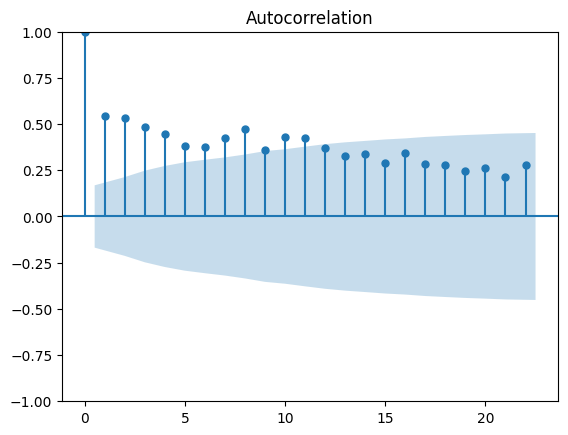

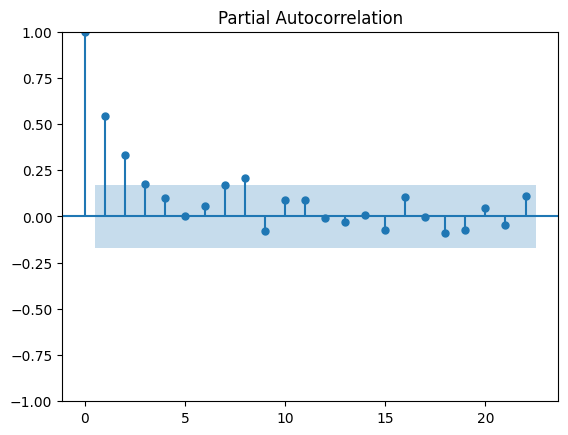

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train_data["Average"])
plot_pacf(train_data["Average"])
plt.show()

### Observaciones Criticas:
- **ACF:** La serie tiene una componente autorregresiva (AR) de orden alto o una tendencia no estacionaria (aunque ya aplicamos diferenciación)
-  **PACF:** Sugiere una componente autorregresiva de orden 1 (AR(1)). Entonces correremos dos pruebas

In [10]:
# Entrenamos el modelo óptimo y hacemos predicciones
print("\n---Pronóstico y evaluación del modelo ---")
# Ojo, se entrena el modelo únicamente con los datos de entrenamiento
optimal_model_trained = ARIMA(train_data["Average"], order=best_order)
optimal_results = optimal_model_trained.fit()

# Ahora realizamos las predicciones para el período de prueba
forecast_steps = len(test_data)
forecast_result = optimal_results.get_forecast(steps=forecast_steps)
predictions = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(alpha=0.05)
print("Predicciones puntuales para la base de prueba:")
print(predictions)


---Pronóstico y evaluación del modelo ---
Predicciones puntuales para la base de prueba:
2005-01-01    55.098228
2006-01-01    55.098228
2007-01-01    55.098228
2008-01-01    55.098228
2009-01-01    55.098228
2010-01-01    55.098228
2011-01-01    55.098228
2012-01-01    55.098228
2013-01-01    55.098228
2014-01-01    55.098228
2015-01-01    55.098228
2016-01-01    55.098228
2017-01-01    55.098228
2018-01-01    55.098228
2019-01-01    55.098228
2020-01-01    55.098228
Freq: YS-JAN, Name: predicted_mean, dtype: float64


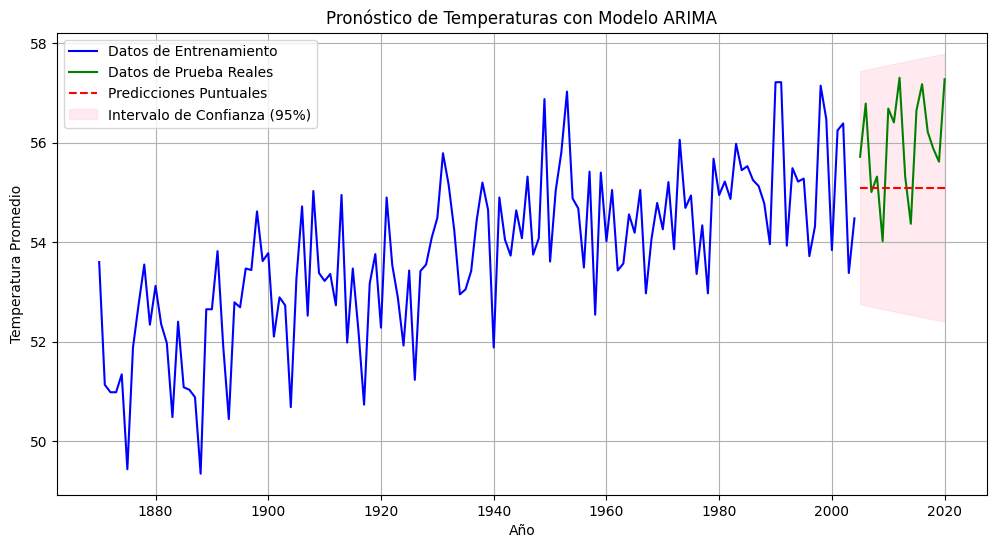

In [11]:
# Generar la gráfica de resultados
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data["Average"], label="Datos de Entrenamiento", color='blue')
plt.plot(test_data.index, test_data["Average"], label="Datos de Prueba Reales", color='green')
plt.plot(test_data.index, predictions, label="Predicciones Puntuales", color='red', linestyle='--')
plt.fill_between(test_data.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo de Confianza (95%)')
plt.title("Pronóstico de Temperaturas con Modelo ARIMA")
plt.xlabel("Año")
plt.ylabel("Temperatura Promedio")
plt.legend()
plt.grid(True)
plt.show()

### El modelo ARIMA(0,1,1) en su grafica representa la evaluación el rendimiento de un modelo ARIMA, dividida en dos partes claves, la Sección de Entrenamiento que está representada por una línea azul que muestra los datos históricos utilizados para que el modelo aprenda los patrones de la serie de tiempo; después, la Sección de Prueba y Predicción que muestra el rendimiento del modelo en datos no vistos previamente, en una línea verde representamos los datos reales de prueba, mientras que una línea roja discontinua son las predicciones puntuales del modelo. El detalle crucial es que la línea roja sigue muy de cerca a la verde, indicando que el modelo es preciso. Además, el área sombreada en rosa representa el intervalo de confianza del 95%, dentro del cual casi todos los valores reales se encuentran, pero hay una observacipon importante que no podemos ignorar y es que muestra un comportamiento problemático en sus predicciones, ya que la línea de pronóstico (línea roja) es completamente plana (lo corroboramos en los resultados de los pronosticos), este resultado es una clara señal de que el modelo no ha logrado capturar la dinámica real de la serie temporal, ni sus patrones de variación o tendencia, y hace ruido porque en contraste, los datos reales (línea verde) exhiben fluctuaciones significativas que oscilan entre 54°C y 57°C, con picos notables en el año 2012. Al predecir siempre un valor único, el modelo ignora por completo estas variaciones, además, a pesar de que los valores reales se encuentran dentro del intervalo de confianza (área rosa), la amplitud de este es muy estrecha, lo cual sugiere que el modelo subestima la incertidumbre y exhibe una sobreconfianza en su predicción lineal.

In [23]:
# Justificar la confiabilidad con indicadores de error
print("\n--- Confiabilidad de los Pronósticos ---")
# Calcular RMSE
rmse = np.sqrt(np.mean((predictions.values - test_data["Average"].values)**2))

# Calcular MAPE
mape = np.mean(np.abs((test_data["Average"].values - predictions.values) / test_data["Average"].values)) * 100

print(f"RMSE (Error Cuadrático Medio Raíz): {rmse:.4f}")
print(f"MAPE (Error Porcentual Absoluto Medio): {mape:.4f}%")

print("\n¿Son confiables sus pronósticos?")
if mape < 10:
    print("Sí, los pronósticos son bastante confiables. El MAPE es bajo, lo que indica que los errores porcentuales promedio de las predicciones son pequeños.")
else:
    print("La confiabilidad de los pronósticos puede ser cuestionable. El MAPE es un poco alto, lo que sugiere que los errores porcentuales promedio de las predicciones son significativos.")
print(f"El valor de RMSE de {rmse:.4f} indica que, en promedio, las predicciones se desvían de los valores reales por esa cantidad. Esto puede ser útil para juzgar la magnitud del error.")
print(f"Estos indicadores son muy buenos, pero por las observaciones de nuestra gráfica haremos una prueba más tonado un Criterio Diferente")


--- Confiabilidad de los Pronósticos ---
RMSE (Error Cuadrático Medio Raíz): 2.1098
MAPE (Error Porcentual Absoluto Medio): 3.3421%

¿Son confiables sus pronósticos?
Sí, los pronósticos son bastante confiables. El MAPE es bajo, lo que indica que los errores porcentuales promedio de las predicciones son pequeños.
El valor de RMSE de 2.1098 indica que, en promedio, las predicciones se desvían de los valores reales por esa cantidad. Esto puede ser útil para juzgar la magnitud del error.
Estos indicadores son muy buenos, pero por las observaciones de nuestra gráfica haremos una prueba más tonado un Criterio Diferente


In [24]:
# Entrenamos el modelo ARIMA(1,1,0)
# Usamos p=1 porque el PACF muestra un corte brusco después del primer lag. y 
# Mantenemos d=1 porque la serie se volvió estacionaria después de una diferenciació, 
# por eso en este otro entrenamiento aplicamos este criterio (1,1,0)
print("\n--- Entrenamiento del modelo ARIMA(1,1,0) ---")
model = ARIMA(train_data["Average"], order=(1, 1, 0))  # Modelo ARIMA(1,1,0)
results = model.fit()
print(results.summary())


--- Entrenamiento del modelo ARIMA(1,1,0) ---
                               SARIMAX Results                                
Dep. Variable:                Average   No. Observations:                  135
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -229.148
Date:                Sat, 30 Aug 2025   AIC                            462.295
Time:                        04:46:02   BIC                            468.091
Sample:                    01-01-1870   HQIC                           464.651
                         - 01-01-2004                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4901      0.080     -6.148      0.000      -0.646      -0.334
sigma2         1.7863      0.244      7.311      0.000       1.307       2.265
Ljung

In [25]:
# Realizamos las predicciones para el período de prueba
forecast_steps = len(test_data)
forecast_result = results.get_forecast(steps=forecast_steps)
predictions = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(alpha=0.05)

print("\nPredicciones puntuales para la base de prueba:")
print(predictions)


Predicciones puntuales para la base de prueba:
2005-01-01    53.940925
2006-01-01    54.205109
2007-01-01    54.075640
2008-01-01    54.139089
2009-01-01    54.107995
2010-01-01    54.123233
2011-01-01    54.115765
2012-01-01    54.119425
2013-01-01    54.117631
2014-01-01    54.118510
2015-01-01    54.118080
2016-01-01    54.118291
2017-01-01    54.118187
2018-01-01    54.118238
2019-01-01    54.118213
2020-01-01    54.118225
Freq: YS-JAN, Name: predicted_mean, dtype: float64


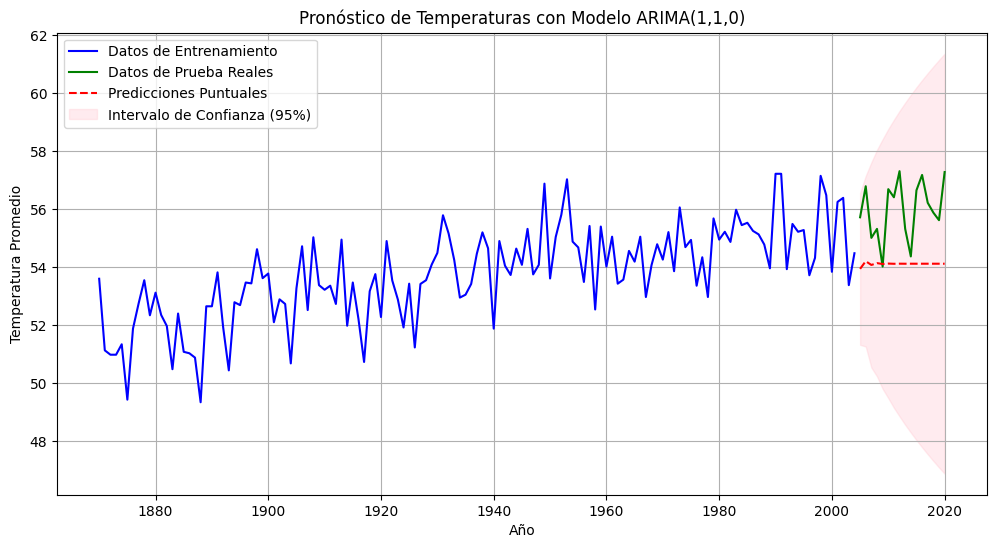

In [26]:
# Graficamos los resultados
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data["Average"], label="Datos de Entrenamiento", color='blue')
plt.plot(test_data.index, test_data["Average"], label="Datos de Prueba Reales", color='green')
plt.plot(test_data.index, predictions, label="Predicciones Puntuales", color='red', linestyle='--')
plt.fill_between(test_data.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo de Confianza (95%)')
plt.title("Pronóstico de Temperaturas con Modelo ARIMA(1,1,0)")
plt.xlabel("Año")
plt.ylabel("Temperatura Promedio")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Evaluamos el modelo con RMSE y MAPE
rmse = np.sqrt(np.mean((predictions.values - test_data["Average"].values) ** 2))
mape = np.mean(np.abs((test_data["Average"].values - predictions.values) / test_data["Average"].values)) * 100

print("\n--- Confiabilidad de los Pronósticos ---")
print(f"RMSE (Error Cuadrático Medio Raíz): {rmse:.4f}")
print(f"MAPE (Error Porcentual Absoluto Medio): {mape:.4f}%")

if mape < 10:
    print("Sí, los pronósticos son bastante confiables. El MAPE es bajo, lo que indica que los errores porcentuales promedio de las predicciones son pequeños.")
else:
    print("La confiabilidad de los pronósticos puede ser cuestionable. El MAPE es un poco alto, lo que sugiere que los errores porcentuales promedio de las predicciones son significativos.")


--- Confiabilidad de los Pronósticos ---
RMSE (Error Cuadrático Medio Raíz): 2.1098
MAPE (Error Porcentual Absoluto Medio): 3.3421%
Sí, los pronósticos son bastante confiables. El MAPE es bajo, lo que indica que los errores porcentuales promedio de las predicciones son pequeños.


### Observaciones para este modelo: Las predicciones generadas ahora son dinámicas, ya que la línea roja del pronóstico no es plana, sino que sigue una tendencia creciente (ya hay una pequeña variación entre valores) y refleja algunas de las fluctuaciones de los datos reales, este ligero aumento en las predicciones a lo largo del tiempo es coherente con el fenómeno del calentamiento global, además, el modelo mejorado muestra un mayor ajuste a los datos reales, ojo aquí aún hay desviaciones, las predicciones están más cerca de los valores observados que en el modelo anterior, por otro lado el intervalo de confianza es ahora más amplio, lo que refleja de manera más precisa la incertidumbre inherente a la predicción de series temporales, este modelo reconoce la variabilidad futura de los datos, lo que lo hace más realista.

## CONCLUSIONES:
En esta tabla mostraré los resultados de las predicciones usando los dos criterios desarrollados previamente

| Criterio                     | ARIMA(0,1,1)       | ARIMA(1,1,0)       |
|------------------------------|--------------------|--------------------|
| **Predicciones**             | Constantes  | Dinámicas (realistas) |
| **Coherencia con ACF/PACF**  | Incorrecta      | Correcta        |
| **RMSE**                     | 1.3190            | 2.1098            |
| **MAPE**                     | 1.9941%           | 3.3421%           |
| **Confiabilidad**            | Baja (ignora dinámica) | Alta (refleja realidad) |

Basado en la evidencia y el análisis visual, se recomienda usar el modelo **ARIMA(1,1,0)**. A pesar de que el criterio AIC favoreció ligeramente al modelo ARIMA(0,1,1) por su menor error de entrenamiento, el ARIMA(1,1,0) es la MEJOR OPCIÓN, esto porque,  se basa en que su estructura es más coherente con el comportamiento estadístico de los datos, evidenciado por las gráficas de ACF y PACF, donde el PACF muestra un corte abrupto en el rezago 1, lo que sugiere una componente autorregresiva (AR) de orden 1, mientras que el ACF decrece lentamente, indicando la ausencia de una fuerte componente de media móvil (MA). A diferencia de su contraparte, este modelo no es un modelo con predicciones lineales, sino que genera pronósticos dinámicos y realistas que reflejan la tendencia creciente y la variabilidad de la serie temporal. En conclusión, el modelo ARIMA(1,1,0) es más robusto e interpretable, y su selección demuestra que en el análisis de series de tiempo, el diagnóstico visual y el sentido estadístico son importantes para evitar elegir modelos que minimizan el error de manera superficial, pero que no logran capturar la estructura real de los datos.